BlazePose is a novel convolutional neural network architecture for human pose estimation that can run in real-time on mobile devices. It can detect 33 body keypoints, including face, hands, and feet, which are useful for applications like fitness, dance, and gesture control. BlazePose is based on a two-step detector-tracker pipeline that first locates the pose region-of-interest and then predicts the keypoints from it. BlazePose outperforms existing pose models in terms of accuracy, speed, and memory. BlazePose can also provide clinically viable body keypoints for virtual motion assessment.


[
https://arxiv.org/abs/2006.10204
](https://)



#Installations and dependensies

In [1]:
#@title Mediapipe instalation
!pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable


## Download tools from github:

In [2]:
user = "ItayCoifman"
repo = "blazepose-mediapipe-example"
src_dir = "tools"
pyfile = "video.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "visualize.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "utils.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};

--2025-12-07 14:32:18--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/video.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 7213 (7,0K) [text/plain]
Enregistre : ‘video.py’

video.py            100%[===================>]   7,04K  --.-KB/s    ds 0s      

2025-12-07 14:32:19 (37,7 MB/s) - ‘video.py’ enregistré [7213/7213]

--2025-12-07 14:32:19--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/visualize.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443… connecté.
requête HTTP transmise, en attente de la réponse

## Imports

In [3]:
# from tools import video,utils,visualize
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from video import Video
import visualize
from utils import landmarks_2_table
import mediapipe as mp
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output, display
import nbimporter
from extract_videos_by_label import get_DESRes_videos_by_label, get_jester_videos_by_label



2025-12-07 14:32:22.072197: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 14:32:22.072913: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 14:32:22.075349: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 14:32:22.082067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765085542.093414    4734 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765085542.09

## Functions

In [5]:
def video_pose_estimation_2D(video_path: str,
                          output_path: str = None,
                          save_video: bool = False,
                          verbose: bool = True):
    """
    Applique BlazePose à une vidéo.

    Args:
        video_path: chemin de la vidéo d'entrée.
        output_path: chemin de la vidéo de sortie (si save_video=True).
        save_video: si True, écrit une vidéo annotée.
        verbose: affichage des infos.

    Returns:
        vid_out (Video ou None),
        marker_df,
        visibility_df
    """
    output = []
    timestamps = []

    vid = Video.from_path(video_path)
    video_name = os.path.basename(video_path)

    # Reader
    vid_cap = cv2.VideoCapture(vid.path)

    # Writer optionnel
    video_writer = None
    if save_video:
        if output_path is None:
            base, ext = os.path.splitext(video_path)
            output_path = base + "_pose.mp4"
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        video_writer = cv2.VideoWriter(output_path, fourcc, vid.fps, (vid.width, vid.height))

    if verbose:
        print(f"Processing- Name- {video_name}:")
        print(f" Width- {vid.width}, Height- {vid.height} ")
        print(f" number of frames- {vid.nFrames}, Fps- {vid.fps} ")
        print(f" Path-{video_path} \n")

    # BlazePose
    with mp.solutions.pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:

        for frame_index in tqdm(range(vid.nFrames)):
            success, img = vid_cap.read()
            if not success:
                break

            # BGR -> RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # timestamp
            timestamps.append(vid_cap.get(cv2.CAP_PROP_POS_MSEC))

            # Inference
            results = pose.process(img_rgb)
            output.append(results)

            # Dessin + écriture vidéo seulement si demandé
            if save_video and video_writer is not None:
                img_out = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
                mp.solutions.drawing_utils.draw_landmarks(
                    img_out,
                    results.pose_landmarks,
                    mp.solutions.pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp.solutions.drawing_styles.get_default_pose_landmarks_style()
                )
                video_writer.write(img_out)

    # Fermer ressources
    if video_writer is not None:
        video_writer.release()
    cv2.destroyAllWindows()

    # Landmarks -> tables
    try:
        marker_df, visibility_df = landmarks_2_table(
            output,
            time_vec=np.array(timestamps) / 1000.0
        )
    except Exception as e:
        print("⚠️ landmarks_2_table a échoué:", repr(e))
        marker_df, visibility_df = output, []
        print("please replace the video")

    vid_out = Video.from_path(output_path) if (save_video and output_path is not None) else None
    return vid_out, marker_df, visibility_df


# BlazePose Mediapipe - Extract Pose Estimation From Video:

## Upload your video

Labels disponibles : ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']

In [7]:
#use case
videos = get_DESRes_videos_by_label("point", 10)
videos


['GESRes_filtered_gestures/point/1666_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/942_Politician3_point_forward.mp4',
 'GESRes_filtered_gestures/point/1171_Clinician1_point_forward.mp4',
 'GESRes_filtered_gestures/point/864_Politician3_point_up.mp4',
 'GESRes_filtered_gestures/point/859_Politician3_point_moving.mp4',
 'GESRes_filtered_gestures/point/838_Politician3_point_up.mp4',
 'GESRes_filtered_gestures/point/834_Politician3_point_to_side.mp4',
 'GESRes_filtered_gestures/point/1673_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/2174_Lecturer3_point_to_side.mp4',
 'GESRes_filtered_gestures/point/863_Politician3_point_forward.mp4']

Labels disponibles : ['Drumming Fingers','Pushing Two Fingers Away','Sliding Two Fingers Down','Stop Sign','Swiping Up','Turning Hand Counterclockwise','Zooming Out With Two Fingers',
				'Pulling Hand In' ,'Rolling Hand Backward','Sliding Two Fingers Left'  , 'Swiping Down',  'Thumb Down' ,'Zooming In With Full Hand',
				'Pulling Two Fingers In','Rolling Hand Forward','Sliding Two Fingers Right','Swiping Left',  'Thumb Up' , 'Zooming In With Two Fingers',
				'Pushing Hand Away','Shaking Hand','Sliding Two Fingers Up', 'Swiping Right','Turning Hand Clockwise' ,'Zooming Out With Full Hand']


In [8]:
videos = get_jester_videos_by_label("Stop Sign", 5)
videos

['Jester_filtered_gestures/Stop Sign/34959.mp4',
 'Jester_filtered_gestures/Stop Sign/50587.mp4',
 'Jester_filtered_gestures/Stop Sign/7882.mp4',
 'Jester_filtered_gestures/Stop Sign/47616.mp4',
 'Jester_filtered_gestures/Stop Sign/143162.mp4']

## Veiw your results
Notice- Convert function is only used for presenting Video in google Colab

# Normalization

In [36]:
from scipy.signal import savgol_filter

def smooth_sequence(data, window=9, poly=3):
    """
    data : (T, D)
    Lisse chaque colonne indépendamment.
    """
    return savgol_filter(data, window_length=window, polyorder=poly, axis=0)


In [58]:
KEYPOINTS = [0, 2, 5] + list(range(7, 25)) # keypoints à utiliser
VIS_THRESH = 0.5  # seuil de visibilité (à ajuster si besoin)


def marker_to_traj_vec(marker_df,
                       visibility_df,
                       keypoints=KEYPOINTS,
                       target_len: int = 50,
                       vis_thresh: float = VIS_THRESH) -> np.ndarray:
    """
    Transforme marker_df (T_raw, 100) + visibility_df en une trajectoire
    normalisée et vectorisée pour DMP.

    Accepte indifféremment:
      - marker_df : np.ndarray ou pandas.DataFrame
      - visibility_df : np.ndarray ou pandas.DataFrame

    Retourne:
        traj_vec : (T, 2 * len(keypoints))  -> typiquement (50, 32)
        (coords = (y,z) normalisés par les épaules, resamplés en target_len)
    """

    # ---- 0) Conversion éventuelle DataFrame -> ndarray ----
    if isinstance(marker_df, pd.DataFrame):
        marker_df = marker_df.to_numpy()
    if isinstance(visibility_df, pd.DataFrame):
        visibility_df = visibility_df.to_numpy()

    T_raw = marker_df.shape[0]
    n_kp = len(keypoints)

    # -------- 1) Récupérer le temps --------
    t_src = marker_df[:, 0]  # (T_raw,)

    # -------- 2) Extraire (y, z) pour les keypoints choisis --------
    # marker_df: [time, x0,y0,z0, x1,y1,z1, ...]
    seq_yz = np.zeros((T_raw, n_kp, 2), dtype=float)  # (T_raw, 16, 2)

    for i, kp in enumerate(keypoints):
        base = 1 + 3 * kp  # x = base, y = base+1, z = base+2
        y_col = base + 1
        z_col = base + 2
        seq_yz[:, i, 0] = marker_df[:, y_col]
        seq_yz[:, i, 1] = marker_df[:, z_col]

    # -------- 3) Appliquer le masque de visibilité --------
    # visibility_df: [time, vis_0, vis_1, ..., vis_32]
    vis_sel = np.zeros((T_raw, n_kp), dtype=float)
    for i, kp in enumerate(keypoints):
        vis_col = 1 + kp
        vis_sel[:, i] = visibility_df[:, vis_col]

    # Mettre les points peu visibles à NaN
    mask_invis = (vis_sel < vis_thresh) | ~np.isfinite(vis_sel)
    seq_yz[mask_invis, :] = np.nan

    # -------- 4) Remplir les NaN par interpolation temporelle --------
    # On interpole chaque dimension (joint, coord) indépendamment
    seq_flat = seq_yz.reshape(T_raw, -1)  # (T_raw, n_kp*2)
    
    # Apply a Savitzky-Golay filter to an array.
    seq_flat = smooth_sequence(seq_flat, window=9, poly=3)

    for d in range(seq_flat.shape[1]):
        vals = seq_flat[:, d]
        finite = np.isfinite(vals)
        if finite.sum() >= 2:
            # interpolation sur les indices de temps (ou t_src si tu préfères)
            seq_flat[:, d] = np.interp(
                np.arange(T_raw),
                np.arange(T_raw)[finite],
                vals[finite]
            )
        else:
            # si quasi rien de valide : on met à 0
            seq_flat[:, d] = 0.0

    seq_yz_filled = seq_flat.reshape(T_raw, n_kp, 2)  # (T_raw, 16, 2)

    # -------- 5) Normalisation par les épaules (centrage + scale) --------
    # On suppose que 11 et 12 sont dans keypoints
    try:
        idx_sh_l = keypoints.index(11)
        idx_sh_r = keypoints.index(12)
    except ValueError:
        raise ValueError("Les keypoints 11 et 12 (épaules) doivent être dans KEYPOINTS.")

    shoulder_L = seq_yz_filled[:, idx_sh_l, :]  # (T_raw, 2)
    shoulder_R = seq_yz_filled[:, idx_sh_r, :]  # (T_raw, 2)

    centers = 0.5 * (shoulder_L + shoulder_R)  # (T_raw, 2)
    seq_centered = seq_yz_filled - centers[:, None, :]  # (T_raw, 16, 2)

    # Distance épaule-épaule pour chaque frame
    shoulder_dist = np.linalg.norm(shoulder_R - shoulder_L, axis=1)  # (T_raw,)
    finite_sd = shoulder_dist[np.isfinite(shoulder_dist) & (shoulder_dist > 1e-6)]
    if finite_sd.size == 0:
        scale = 1.0
    else:
        scale = np.mean(finite_sd)

    seq_norm = seq_centered / scale  # (T_raw, 16, 2)

    # -------- 6) Normalisation temporelle à target_len frames --------
    if target_len is not None and target_len > 0:
        # On interpole dans le temps réel t_src
        t_new = np.linspace(t_src[0], t_src[-1], target_len)
        seq_norm_flat = seq_norm.reshape(T_raw, -1)  # (T_raw, 32)
        seq_resampled_flat = np.zeros((target_len, seq_norm_flat.shape[1]), dtype=float)

        for d in range(seq_norm_flat.shape[1]):
            seq_resampled_flat[:, d] = np.interp(
                t_new, t_src, seq_norm_flat[:, d]
            )

        seq_resampled = seq_resampled_flat.reshape(target_len, n_kp, 2)  # (target_len, 16, 2)
        T_out = target_len
    else:
        seq_resampled = seq_norm
        T_out = T_raw

    # -------- 7) Vectorisation finale pour DMP : (T_out, 2 * n_kp) --------
    traj_vec = seq_resampled.reshape(T_out, n_kp * 2)  # (T_out, 32)

    return traj_vec


# DMP


In [57]:
class DMPVector:
    def __init__(self, n_basis: int = 20):
        self.n_basis = n_basis #number of gaussians
        self.centers = None
        self.widths = None
        self.W = None       # (n_basis, D)
        self.y0 = None      # (D,)
        self.g = None       # (D,)
        self.T_train = None

    #define each psi function
    def _basis_functions(self, T: int):
        t = np.linspace(0.0, 1.0, T)
        self.centers = np.linspace(0.0, 1.0, self.n_basis)
        self.widths = np.ones(self.n_basis) * (self.n_basis ** 2)
        psi = np.exp(-self.widths * (t[:, None] - self.centers[None, :])**2)
        return psi, t

    def fit(self, Y: np.ndarray):
        T, D = Y.shape
        self.T_train = T
        self.y0 = Y[0].copy()
        self.g  = Y[-1].copy()     #goal point for each trajectory

        psi, t = self._basis_functions(T)   # psi: (T, n_basis)

        # Composante linéaire entre y0 et g pour chaque dimension
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))   # (T, D)

        # Composante non linéaire à approximer
        F_target = Y - Y_lin                                # (T, D)

        # Normalisation des bases
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                           # (T, n_basis)

        # Résolution des poids W dans F_target ≈ psi_norm @ W
        # psi_norm: (T, n_basis), F_target: (T, D) -> W: (n_basis, D)
        self.W, _, _, _ = np.linalg.lstsq(psi_norm, F_target, rcond=None)

    def fit_multi(self, Y_batch: np.ndarray):
        """
        Y_batch : (N, T, D) — ensemble de N démos pour un même geste
        Apprend un seul W en empilant toutes les F_target.
        """
        N, T, D = Y_batch.shape
        self.T_train = T

        # base functions communes
        psi, t = self._basis_functions(T)           # (T, n_basis)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                    # (T, n_basis)

        # On va empiler toutes les F_target
        F_list = []

        # Pour la partie linéaire de référence, on choisit les moyennes des y0, g
        y0_all = []
        g_all  = []

        for i in range(N):
            Y = Y_batch[i]              # (T, D)
            y0_i = Y[0].copy()
            g_i  = Y[-1].copy()

            y0_all.append(y0_i)
            g_all.append(g_i)

            Y_lin_i = y0_i + np.outer(t, (g_i - y0_i))   # (T, D)
            F_i     = Y - Y_lin_i                        # (T, D)
            F_list.append(F_i)

        # Empilement
        F_all = np.concatenate(F_list, axis=0)           # (N*T, D)
        Psi_big = np.tile(psi_norm, (N, 1))              # (N*T, n_basis)

        # Régression globale
        self.W, _, _, _ = np.linalg.lstsq(Psi_big, F_all, rcond=None)

        # y0, g moyens pour ce geste
        self.y0 = np.mean(np.stack(y0_all, axis=0), axis=0)  # (D,)
        self.g  = np.mean(np.stack(g_all, axis=0),  axis=0)  # (D,)


    def rollout(self, T: int = None, amplitude_scale: float = 1.0) -> np.ndarray:
        """
        Génère une nouvelle trajectoire :
        - T : nombre de pas (si None -> même T que l'entraînement)
        - amplitude_scale : scaling global de la partie non-linéaire
        Retour : (T, D)
        """
        if T is None:
            T = self.T_train

        psi, t = self._basis_functions(T)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum

        # F: (T, D)
        F = psi_norm @ self.W * amplitude_scale

        # partie linéaire entre y0 et g
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))

        Y = Y_lin + F
        return Y


# Dataset usage



In [14]:
#Given a label and a number of video, extract marker_df and visibility_df 
#Then, normalize and resample them to build a dataset for DMP training
#output : X (N, T, 32) and video_paths (list of N strings): array of shape (N, T, 32) where N is number of videos

labels_DESRes = ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']
labels_jester_full = ['Drumming Fingers','Pushing Two Fingers Away','Sliding Two Fingers Down','Stop Sign','Swiping Up','Turning Hand Counterclockwise','Zooming Out With Two Fingers',
				'Pulling Hand In' ,'Rolling Hand Backward','Sliding Two Fingers Left'  , 'Swiping Down',  'Thumb Down' ,'Zooming In With Full Hand',
				'Pulling Two Fingers In','Rolling Hand Forward','Sliding Two Fingers Right','Swiping Left',  'Thumb Up' , 'Zooming In With Two Fingers',
				'Pushing Hand Away','Shaking Hand','Sliding Two Fingers Up', 'Swiping Right','Turning Hand Clockwise' ,'Zooming Out With Full Hand']

labels_jester = ['Stop Sign', 'Drumming Fingers', 'Thumb Up', 'Thumb Down', 'Turning Hand Counterclockwise', 'Turning Hand Clockwise', 
                 'Rolling Hand Backward', 'Rolling Hand Forward', 'Pushing Hand Away', 'Shaking Hand']

def build_gesture_dataset(label, n, target_len=50):
    
    if label in labels_DESRes:
        video_paths = get_DESRes_videos_by_label(label, n)
    elif label in labels_jester:
        video_paths = get_jester_videos_by_label(label, n)
    else:
        raise ValueError(f"❌ Label '{label}' non reconnu.")
    
    X = []

    for vp in video_paths:
        try:
            # On ne sauvegarde pas de vidéo ici -> save_video=False
            vid_out, marker_df, visibility_df = video_pose_estimation_2D(
                vp, save_video=False, verbose=False
            )

            traj = marker_to_traj_vec(marker_df, visibility_df, target_len=target_len)
            X.append(traj)   # (T, 32)

        except Exception as e:
            print(f"⚠️ Skip {vp} : {repr(e)}")

    if len(X) == 0:
        raise RuntimeError(
            f"❌ Aucune trajectoire n'a pu être extraite pour le label '{label}'."
        )

    X = np.stack(X, axis=0)  # (N, T, 32)
    return X, video_paths


In [ ]:
X_point, vids_point = build_gesture_dataset("point", 10, target_len=50)
X_point.shape


# Execution example :
Renvoie Y obtenu avec les 10 démo du label "point"

In [16]:
dmp_point = DMPVector(n_basis=20)
dmp_point.fit_multi(X_point)          # on utilise T et D depuis X_point

Y_gen = dmp_point.rollout(T=50)       # (50, 32)
print(Y_gen.shape)


(50, 42)


# Generalization 
Let's create the dictionnary for each label

In [ ]:
gesture_dmps = {}

labels = labels_DESRes + labels_jester

for lab in labels:
    X_lab, vids_lab = build_gesture_dataset(lab, n=100, target_len=50)
    dmp = DMPVector(n_basis=20)
    dmp.fit_multi(X_lab)
    gesture_dmps[lab] = dmp


# Sauvegarder résultat obtenu 

In [18]:
!pip install joblib


Defaulting to user installation because normal site-packages is not writeable


In [19]:
import joblib

# Sauvegarde dans un fichier binaire
joblib.dump(gesture_dmps, "gesture_dmps_2D.joblib")

print("✔️ DMPs saved !")

✔️ DMPs saved !


# Results analysis 

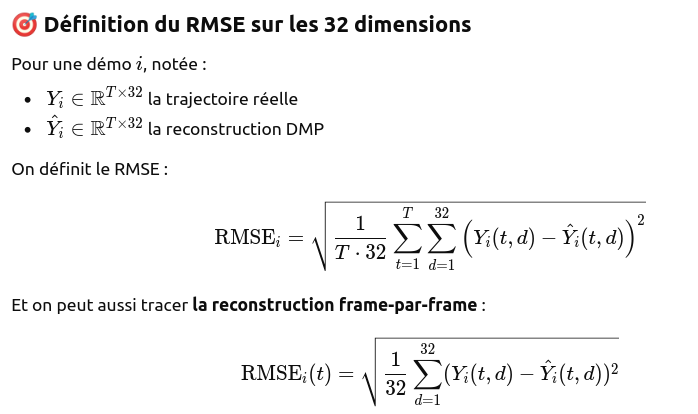

In [43]:
#Function evaluation DMP reconstruction

def evaluate_dmp_reconstruction(dmp, X_batch):
    """
    X_batch : (N, T, D)
    Retourne :
    - rmse_all : (N,) RMSE globale par démo
    - rmse_per_frame : (N, T) RMSE par frame
    """
    N, T, D = X_batch.shape

    # Reconstructions
    Y_hat = np.zeros_like(X_batch)

    for i in range(N):
        Y_hat[i] = dmp.rollout(T=T)  # Reconstruction DMP

    err = X_batch - Y_hat  # (N, T, D)

    rmse_per_frame = np.sqrt(np.mean(err**2, axis=2))  # (N, T)
    rmse_all = np.sqrt(np.mean(err**2, axis=(1,2)))    # (N,)
    rmse_mean = rmse_all.mean()

    return rmse_all, rmse_per_frame, rmse_mean

In [ ]:
def analyse_label(label, n=100, target_len=50, n_basis=30):
    """
    Construit le dataset pour `label`, entraîne un DMP multi-démos,
    calcule les RMSE et trace RMSE par frame (toutes les vidéos + moyenne).

    Retourne :
      - rmse_all        : (N,) RMSE globale par démo
      - rmse_per_frame  : (N, T) RMSE à chaque frame
      - dmp             : le DMPVector entraîné
      - X               : (N, T, D) les trajectoires utilisées
      - vids            : liste des chemins de vidéos
    """

    # 1) Dataset
    X, vids = build_gesture_dataset(label, n=n, target_len=target_len)

    # 2) Train DMP multi-démos
    dmp = DMPVector(n_basis=n_basis)
    dmp.fit_multi(X)

    # 3) Evaluate reconstruction
    rmse_all, rmse_per_frame, rmse_mean = evaluate_dmp_reconstruction(dmp, X)

    # 4) Stats globales
    # print(f"\n=== Résultats pour le label: {label} ===")
    # print("RMSE par démo :", rmse_all)
    # print("RMSE moyenne :", rmse_all.mean())
    # print("RMSE max :", rmse_all.max())
    # print("Number of videos ", rmse_all.shape[0])
    # 5) Plot RMSE per frame
    plt.figure(figsize=(10, 5))
    for i in range(rmse_per_frame.shape[0]):
        plt.plot(rmse_per_frame[i], alpha=0.25)

    # Courbe moyenne
    plt.plot(rmse_per_frame.mean(axis=0), color='red', linewidth=3, label='Moyenne')

    plt.title(f"RMSE per frame for '{label}'")
    plt.xlabel("Frame")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    return rmse_all, rmse_per_frame, rmse_mean, dmp, X, vids

In [62]:
def analyse_label_filtered(label, 
                           n=100, 
                           target_len=50, 
                           n_basis=30, 
                           rmse_threshold=0.35):

    # 1) Dataset
    X_raw, vids_raw = build_gesture_dataset(label, n=n, target_len=target_len)
    N_raw = len(X_raw)

    print(f"\n🔎 {label} : {N_raw} videos loaded")

    # 2) DMP multi-démos
    dmp_full = DMPVector(n_basis=n_basis)
    dmp_full.fit_multi(X_raw)

    # 3) RMSE multi-démos
    rmse_all, rmse_per_frame, rmse_mean = evaluate_dmp_reconstruction(dmp_full, X_raw)

    print(f"📊 Mean RMSE (filtered)  : {rmse_mean:.4f}")
    print(f"📈 RMSE max : {rmse_all.max():.4f}")

    # 4) Filtrage basé sur RMSE multi-démos
    keep_mask = rmse_all < rmse_threshold
    print(f"🧹 Filtrage : {keep_mask.sum()}/{len(keep_mask)} vidéos gardées (< {rmse_threshold})")

    X = X_raw[keep_mask]
    vids = [vids_raw[i] for i in range(N_raw) if keep_mask[i]]   # ⭐ CORRECTIF ICI ⭐

    if len(X) == 0:
        print("⚠️ Aucune vidéo n'a passé le filtrage pour ce label. Analyse ignorée.")
        return None, None, None, None, []


    # 5) Réentraîner le DMP multi-démos
    dmp = DMPVector(n_basis=n_basis)
    dmp.fit_multi(X)

    # 6) RMSE final
    rmse_all_f, rmse_per_frame_f, rmse_mean_f = evaluate_dmp_reconstruction(dmp, X)

    print("\n📊 Mean RMSE (filtered) :", rmse_mean_f)
    print("📈 RMSE max :", rmse_all_f.max())
    print("📉 RMSE min :", rmse_all_f.min())

    # Plot
    plt.figure(figsize=(10, 5))
    for i in range(rmse_per_frame_f.shape[0]):
        plt.plot(rmse_per_frame_f[i], alpha=0.25)

    plt.plot(rmse_per_frame_f.mean(axis=0), color='red', linewidth=3, label='Moyenne')

    plt.title(f"RMSE per frame for '{label}' (filtered)")
    plt.xlabel("Frame")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    return rmse_all_f, rmse_per_frame_f, dmp, X, vids, rmse_all


Utiliser fonction analyse_label("label") pour visualiser les résultats obtenus pour un label.

In [ ]:
analyse_label("Stop Sign", n=50, target_len=50, n_basis=30)

In [ ]:
rmse_all, rmse_per_frame, dmp, Xf, vids_f, rmse_raw = analyse_label_filtered(
    "Stop Sign",
    n=100,
    target_len=50,
    n_basis=40,
    rmse_threshold=0.35
)

# Analyse de tous les labels du dataset DESRes en même temps

In [ ]:
def analyse_full_DESRes(): 
    for i in labels_DESRes:
        print(analyse_label_filtered(i, n=100, target_len=50, n_basis=30)) 
    
analyse_full_DESRes()

### Analyse label from Jester Dataset

In [ ]:
def analyse_full_jester(): 
    for i in labels_jester:
        print(analyse_label_filtered(i, n = 100, target_len=50, n_basis=30)) 
    
analyse_full_jester()